In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df=pd.read_csv('monthly_milk_production.csv', index_col='Date',parse_dates=True)
df.index.freq='MS'

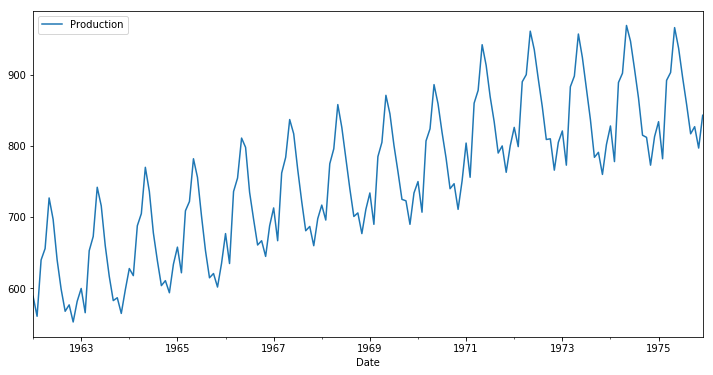

In [3]:
df.plot(figsize=(12,6))

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Freq: MS
Data columns (total 1 columns):
Production    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


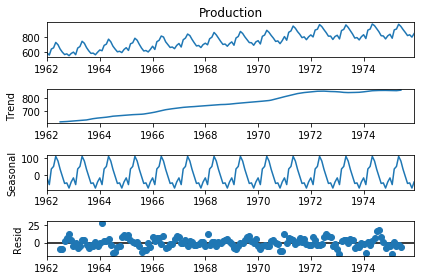

In [5]:
results = seasonal_decompose(df['Production'])
results.plot();#1)same graph abvobe 2)trend 3)seasonal 4) unexpainable noises

In [6]:
len(df)

168

In [7]:
train = df.iloc[:156]
test= df.iloc[156:]

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [9]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [10]:
#input[1,2,3],pred_output[4]|input[2,3,4],pred_output=[5] we use batches like this in our model
from keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
number_of_batches=12 #3 month in 1 batch
number_of_features=1 # we are using only 1 time series it could be more than 1 in case of multiple time seris 
generator = TimeseriesGenerator(scaled_train,scaled_train,length=number_of_batches,batch_size=1)

In [12]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')
X.shape

Given the Array: 
[0.08653846 0.01923077 0.20913462 0.24759615 0.41826923 0.34615385
 0.20913462 0.11057692 0.03605769 0.05769231 0.         0.06971154]
Predict this y: 
 [[0.11298077]]


(1, 12, 1)

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [19]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(number_of_batches,number_of_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
model.fit(generator,epochs=50)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
144/144 [==============================] - 2s 5ms/step - loss: 0.0516
Epoch 2/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0227
Epoch 3/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0149
Epoch 4/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0193
Epoch 5/50
144/144 [==============================] - 

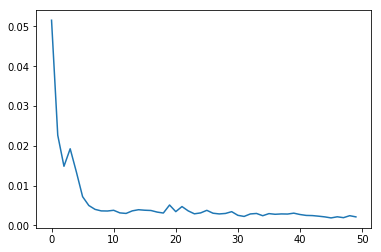

In [21]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [23]:
last_train_batch= scaled_train[-12:]
last_train_batch

array([[0.66105769],
       [0.54086538],
       [0.80769231],
       [0.83894231],
       [1.        ],
       [0.94711538],
       [0.85336538],
       [0.75480769],
       [0.62980769],
       [0.62259615],
       [0.52884615],
       [0.625     ]])

In [24]:
last_train_batch.shape # we have to reshape it like x that is how it is been trained 

(12, 1)

In [25]:
last_train_batch = last_train_batch.reshape((1, number_of_batches,number_of_features))

In [26]:
last_train_batch.shape

(1, 12, 1)

In [27]:
model.predict(last_train_batch)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[0.6510226]], dtype=float32)

In [28]:
scaled_test[0]

array([0.67548077])

In [29]:
test_predictions = []

first_eval_batch = scaled_train[-number_of_batches:]
current_batch = first_eval_batch.reshape((1, number_of_batches, number_of_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)#[:,1:,:],[[current_pred]],axis=1 replacing first number with current_pred


In [30]:
test_predictions

[array([0.6510226], dtype=float32),
 array([0.6251882], dtype=float32),
 array([0.808826], dtype=float32),
 array([0.8788346], dtype=float32),
 array([0.9814875], dtype=float32),
 array([0.9648723], dtype=float32),
 array([0.88576174], dtype=float32),
 array([0.78540415], dtype=float32),
 array([0.66817343], dtype=float32),
 array([0.629844], dtype=float32),
 array([0.5786059], dtype=float32),
 array([0.6145828], dtype=float32)]

In [31]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [32]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Prediction']  = true_predictions

C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


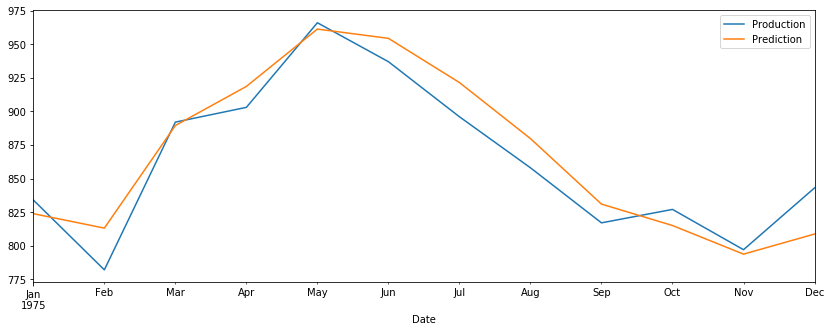

In [33]:
test.plot(figsize=(14,5))

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Prediction']))
print(rmse)

18.91379342743662


In [35]:
scaled_train

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231],
       [0.        ],
       [0.06971154],
       [0.11298077],
       [0.03125   ],
       [0.24038462],
       [0.28846154],
       [0.45432692],
       [0.39182692],
       [0.25721154],
       [0.15384615],
       [0.07211538],
       [0.08173077],
       [0.02884615],
       [0.10817308],
       [0.18028846],
       [0.15625   ],
       [0.32451923],
       [0.36538462],
       [0.52163462],
       [0.43990385],
       [0.30048077],
       [0.20673077],
       [0.12259615],
       [0.13942308],
       [0.09855769],
       [0.19471154],
       [0.25240385],
       [0.16586538],
       [0.375     ],
       [0.40625   ],
       [0.55048077],
       [0.48798077],
       [0.35817308],
       [0.24038462],
       [0.14903846],
       [0.16346154],
       [0.11778846],
       [0.197